**This notebook is an exercise in the [Introduction to Machine Learning](https://www.kaggle.com/learn/intro-to-machine-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/alexisbcook/machine-learning-competitions).**

---


# Introduction

In this exercise, you will create and submit predictions for a Kaggle competition. You can then improve your model (e.g. by adding features) to apply what you've learned and move up the leaderboard.

Begin by running the code cell below to set up code checking and the filepaths for the dataset.

In [1]:
# Set up code checking
from learntools.core import binder
binder.bind(globals())
from learntools.machine_learning.ex7 import *

# Set up filepaths
import os
if not os.path.exists("../input/train.csv"):
    os.symlink("../input/home-data-for-ml-course/train.csv", "../input/train.csv")  
    os.symlink("../input/home-data-for-ml-course/test.csv", "../input/test.csv") 

Here's some of the code you've written so far. Start by running it again.

# Data Define

## Import Library

import library-library yang dibutuhkan
- pandas: untuk memproses data, mulai pembersihan data, manipulasi data, hingga melakukan analisis data
- numpy: untuk memudahkan kita melakukan perhitungan saintifik seperti matriks, aljabar, statistik, dan sebagainya
- missingno:  untuk memvisualisasikan data yang hilang atau data yang tidak lengkap (missing data) pada suatu dataset
- matplotlib: untuk melakukan visualisasi data
- scikit learn: untuk membangun model pembelajaran mesin


In [2]:
# Import helpful libraries

import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Import Data

terdapat dua data yaitu data train dan data test. data train digunakan untuk membuat atau melatih model machine learning, sedangkan data test adalah data yang akan digunakan untuk melakukan prediksi.

In [3]:
# load data
train_data_path = '../input/train.csv'
test_data_path = '../input/test.csv'
home_data_train = pd.read_csv(train_data_path).copy()
home_data_test = pd.read_csv(test_data_path).copy()

# Data Visualization

In [4]:
# simpan kolom-kolom numerik dan non numerik ke dalam variabel terpisah
numeric_cols = home_data_train.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = home_data_train.select_dtypes(exclude=[np.number]).columns.tolist()

In [5]:
# data numerik akan diberi warna, sedangkan non-numerik tidak
home_data_train.head().style.background_gradient(cmap = "viridis")

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000000,8450,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,nan,Attchd,2003.000000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,nan,nan,nan,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000000,9600,Pave,nan,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,nan,nan,nan,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000000,11250,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,nan,nan,nan,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000000,9550,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,nan,nan,nan,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000000,14260,Pave,nan,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,nan,nan,nan,0,12,2008,WD,Normal,250000


## Missing values

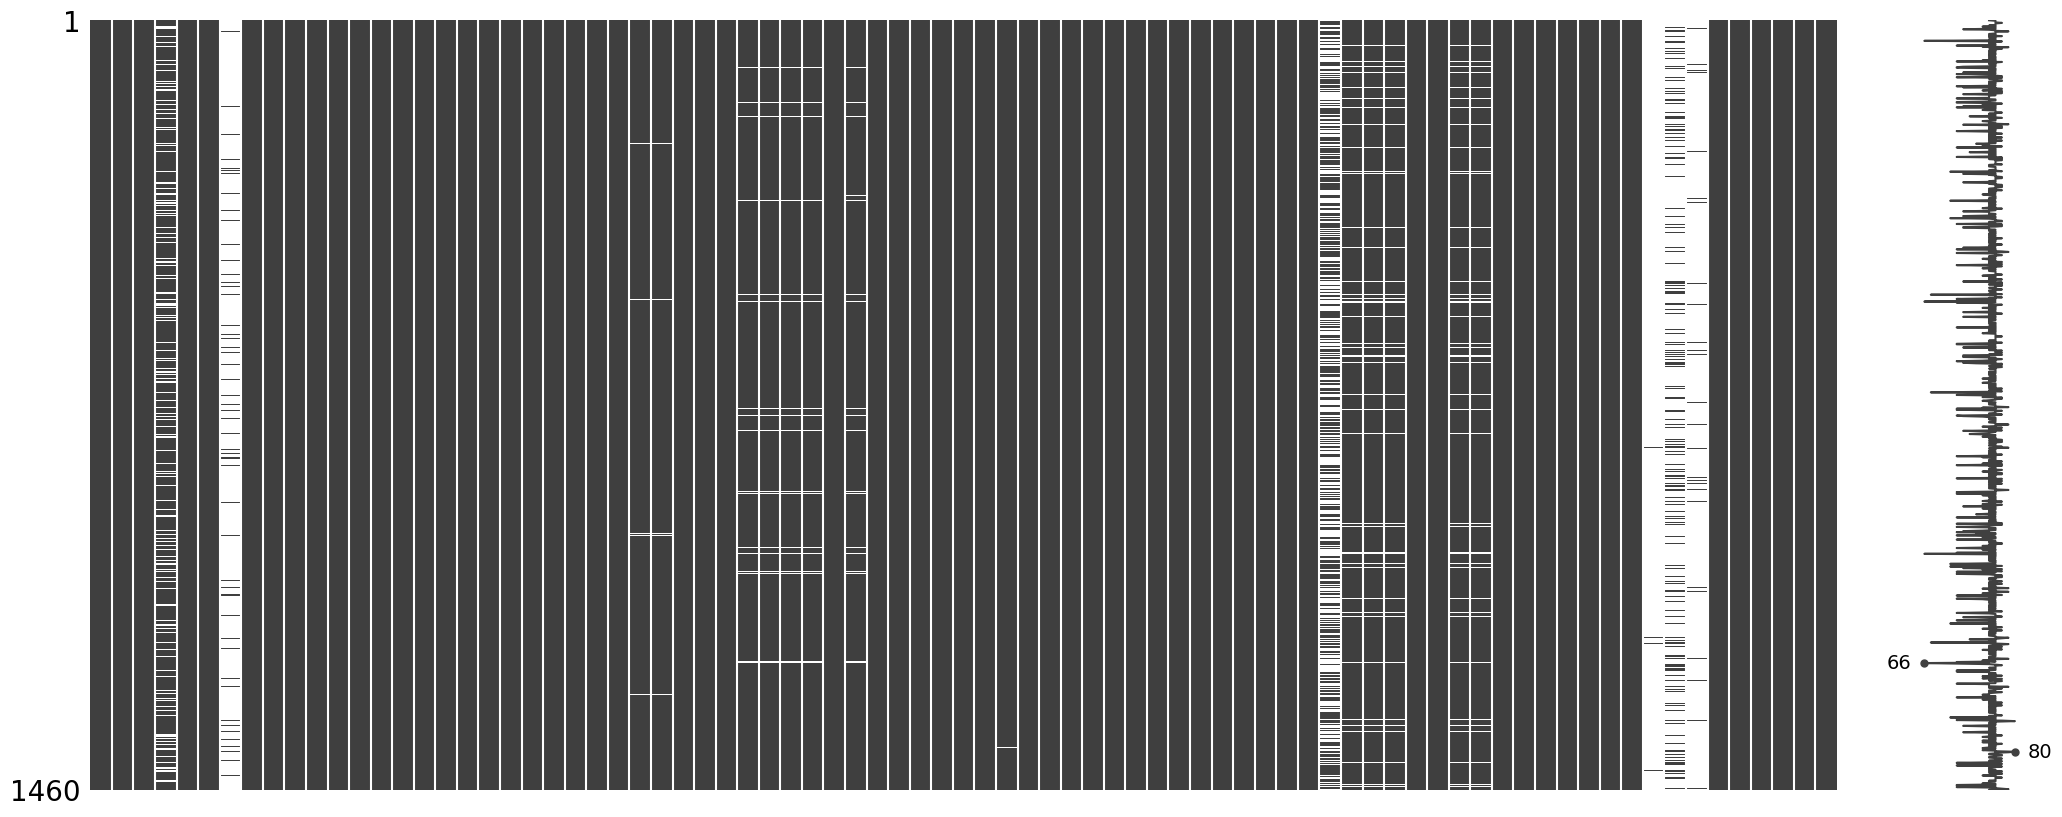

In [6]:
# menampilkan nilai kosong pada data dengan menggunakan library missingno
# ini akan menampilkan data kosong dengan visualisasi matriks nullity
msno.matrix(home_data_train);

In [7]:
def getDataInfo (data_input):
  return pd.DataFrame({"name": data_input.columns, "non-nulls": len(data_input)-data_input.isnull().sum().values, "nulls": data_input.isnull().sum().values, "type": data_input.dtypes.values})

# cek data yang memiliki nilai kosong (terlihat pada kolom nulls)
getDataInfo(home_data_train)

,name,non-nulls,nulls,type
0,Id,1460,0,int64
1,MSSubClass,1460,0,int64
2,MSZoning,1460,0,object
3,LotFrontage,1201,259,float64
4,LotArea,1460,0,int64
...,...,...,...,...
76,MoSold,1460,0,int64
77,YrSold,1460,0,int64
78,SaleType,1460,0,object
79,SaleCondition,1460,0,object


## Histogram

histogram akan menampilkan distribusi frekuensi dari data numerik menjadi bentuk grafik dengan sumbu x merepresentasikan nilai data, dan sumbu y merepresentasikan frekuensi kemunculan data dengan nilai tersebut. semakin tinggi bar histogram, semakin sering nilai data muncul di dalam interval tersebut

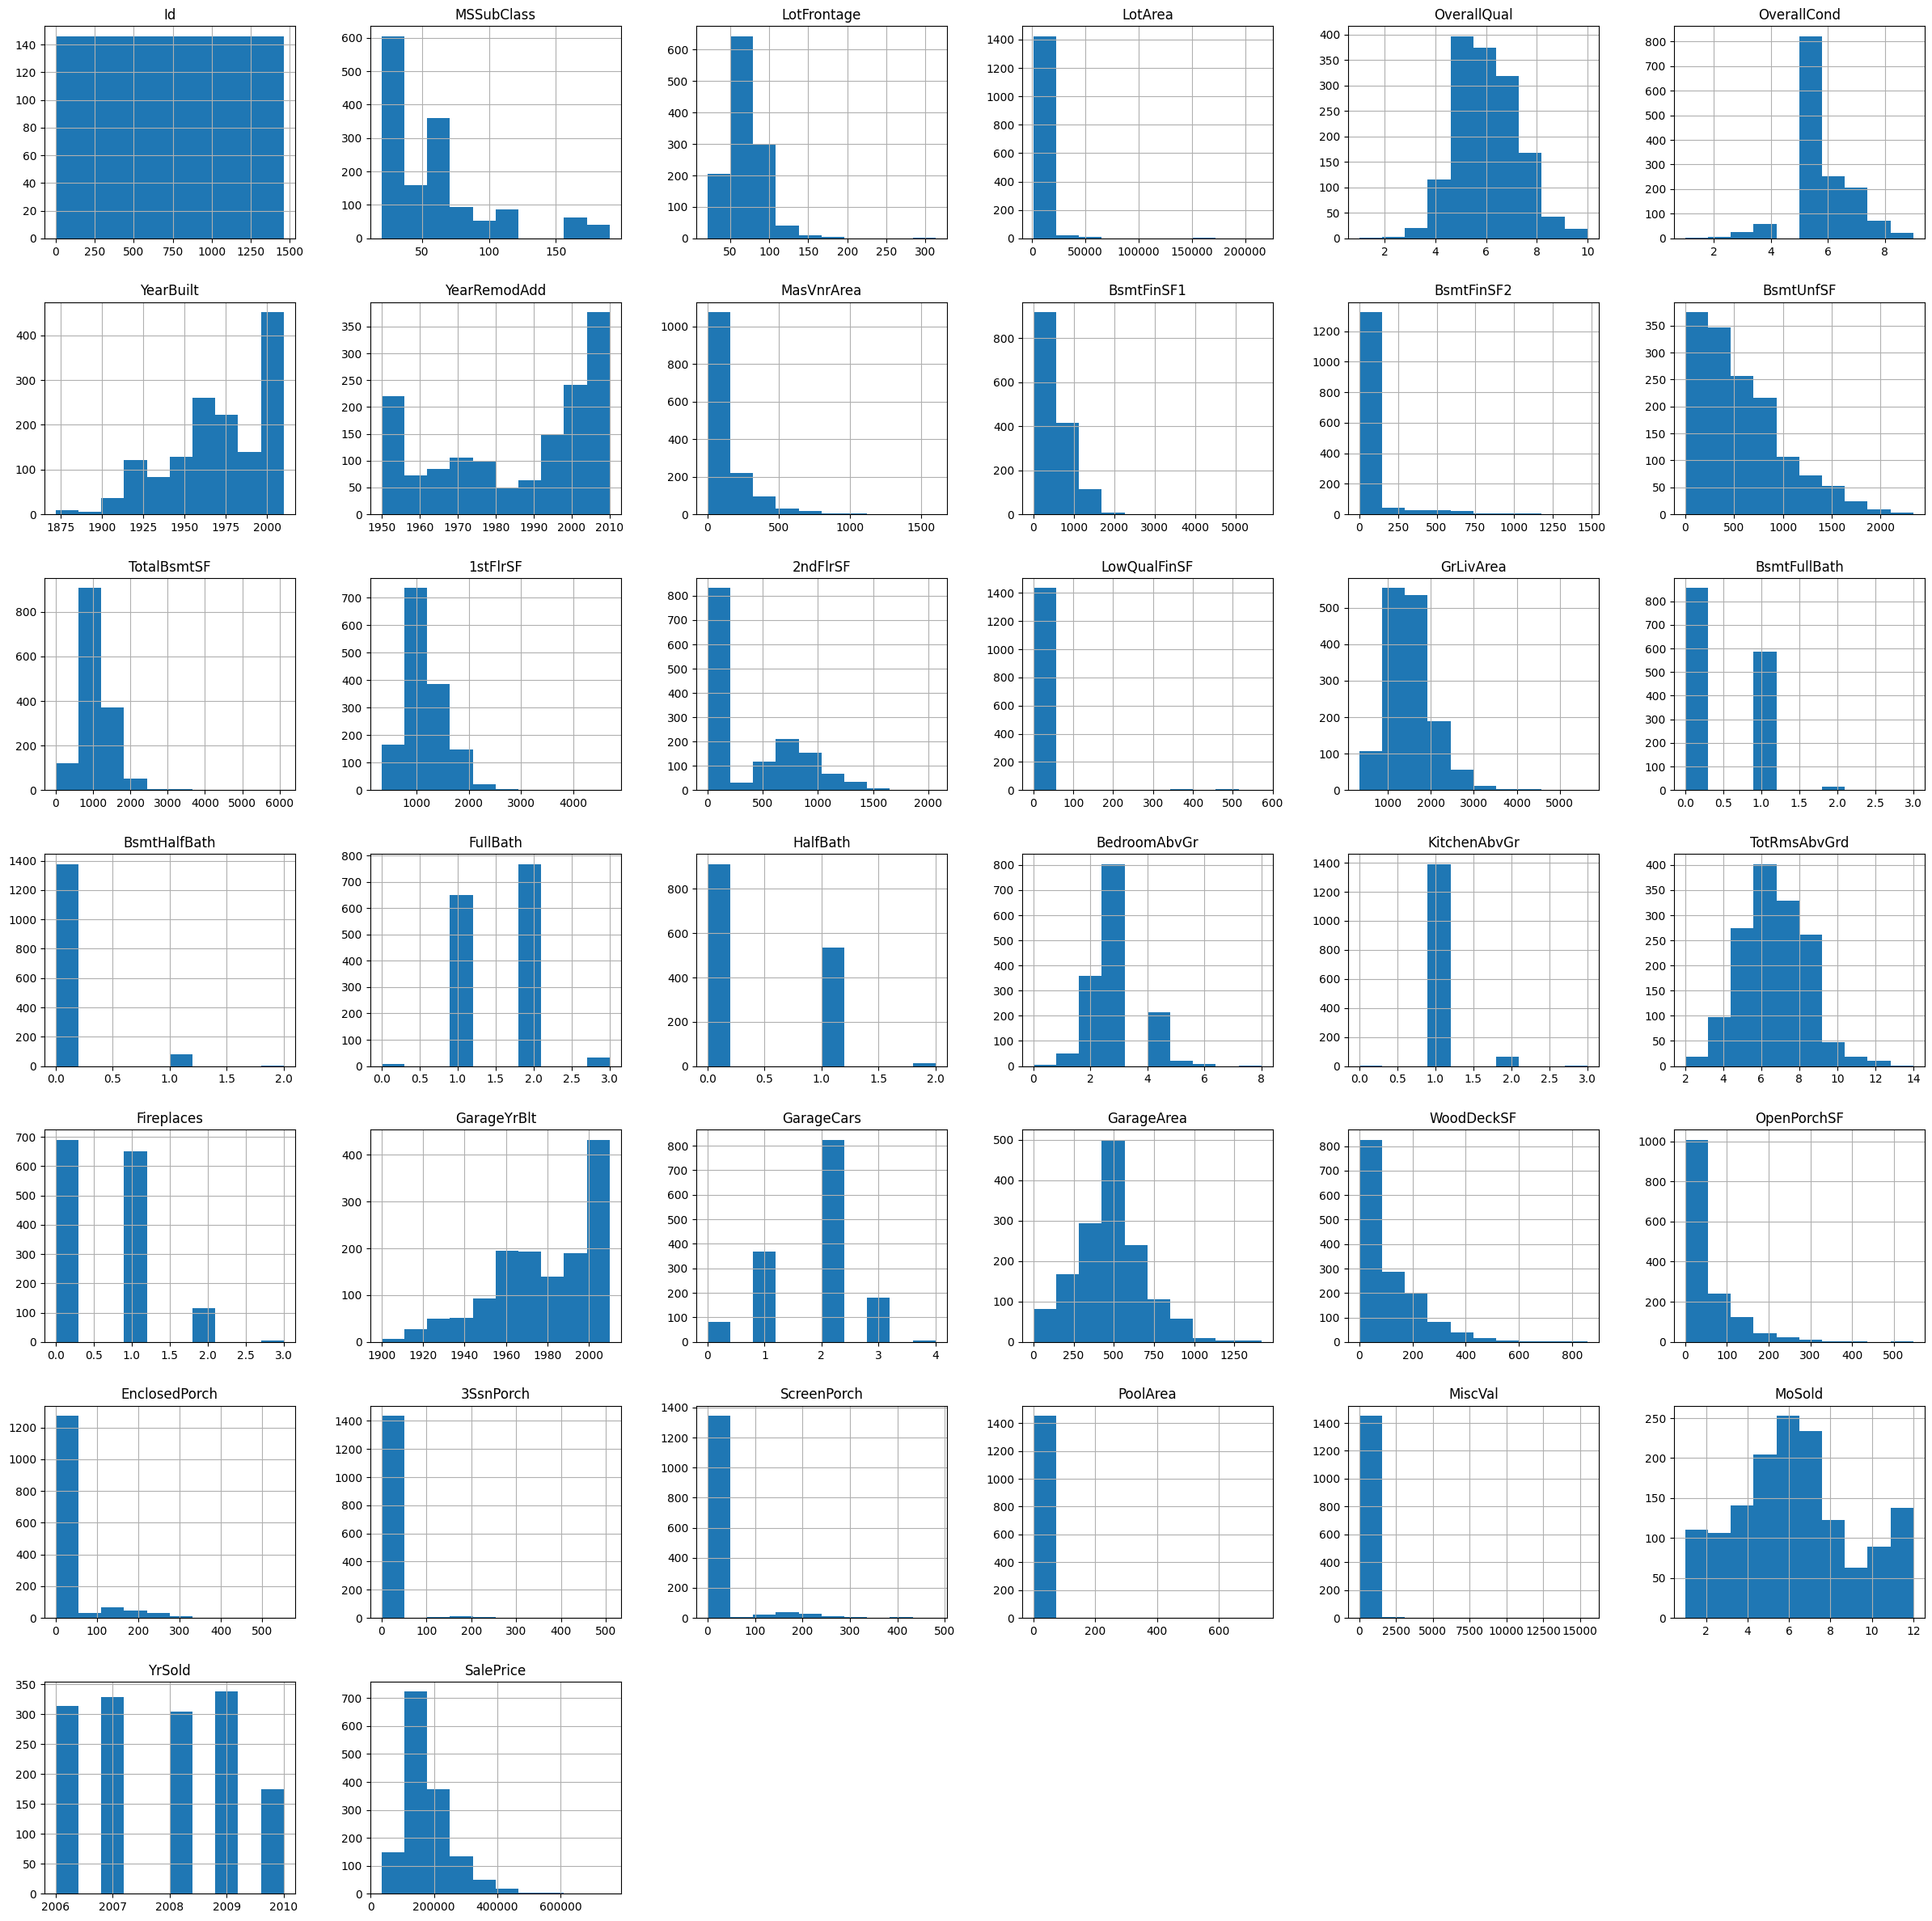

In [8]:
# menampilkan histogram pada setiap kolom
# untuk menampilkan distribusi dari suatu variabel numerik
home_data_train.hist(figsize = (30, 30), legend = False)
plt.show()

# Data Cleaning

data yang telah disediakan sudah bersih dan data siap digunakan tanpa adanya duplikasi, kesalahan input, nilai kosong atau outlier yang signifikan. hanya saja terdapat beberapa nilai kosong, namun nilai kosong tersebut memang tidak memiliki nilai. Sehingga pada data numerik harus diubah menjadi nol, sedangkan untuk data non-numerik tidak perlu diubah karena nantinya akan dikonversi menjadi data numerik menggunakan metode one-hot encoding.

## Isi Data Kosong [data numerik]

In [9]:
# mengisi data numerik yang kosong dengan nilai nol
for col in home_data_train.select_dtypes(include=[np.number]).columns.tolist():
  if home_data_train[col].isna().sum() > 0:
    home_data_train[col] = home_data_train[col].fillna(0)

In [10]:
# lihat kembali nilai kosong pada setiap kolom
getDataInfo(home_data_train) 

,name,non-nulls,nulls,type
0,Id,1460,0,int64
1,MSSubClass,1460,0,int64
2,MSZoning,1460,0,object
3,LotFrontage,1460,0,float64
4,LotArea,1460,0,int64
...,...,...,...,...
76,MoSold,1460,0,int64
77,YrSold,1460,0,int64
78,SaleType,1460,0,object
79,SaleCondition,1460,0,object


## Hapus data dengan nilai ekstrim tinggi [data numerik]

data dengan nilai ekstrem tinggi adalah data yang memiliki nilai yang jauh lebih besar atau lebih kecil dari nilai rata-rata atau median. nilai ekstrem dapat mempengaruhi analisis statistik dan model prediktif, sehingga seringkali perlu diidentifikasi dan dihapus

In [11]:
def remove_extreme_values(df, threshold=3):
    # Remove extreme values from a dataframe using the z-score method.
    
    # Compute the z-score for each data point in the dataframe
    numeric_df = df.select_dtypes(include=[np.number])
    z_scores = np.abs((numeric_df - numeric_df.mean()) / numeric_df.std())

    # hapus data yang memiliki z-score lebih dari threshold
    df = df[(z_scores <= threshold).all(axis=1)]
    return df

# Remove extreme values from all columns of the dataframe
home_data_train = remove_extreme_values(home_data_train)

## Ubah data non-numerik/kategorik

data non-numerik perlu dikonversi menjadi data numerik agar dapat dikenali oleh model. salah satu metode konversi yang akurat adalah dengan metode one-hot encoding, yaitu dengan mengubah variabel kategori menjadi bentuk biner, dengan membuat kolom baru untuk setiap nilai kategori dan menetapkan nilai 1 atau 0 pada setiap baris data untuk menunjukkan apakah variabel tersebut mengambil nilai tertentu atau tidak

In [12]:
# konversi data kategorik menjadi numerik menggunakan metode one-hot encoding
# membuat dummy variables untuk setiap non-numerik kolom
for col in home_data_train.select_dtypes(exclude=[np.number]).columns.tolist():
    dummies = pd.get_dummies(home_data_train[col], prefix=col)
    home_data_train = pd.concat([home_data_train, dummies], axis=1)
    home_data_train.drop(col, axis=1, inplace=True)

In [13]:
# cek apakah data non-numerik telah dikonversi menjadi data numerik
home_data_train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0
6,7,20,75.0,10084,8,5,2004,2005,186.0,1369,...,0,0,0,1,0,0,0,0,1,0
10,11,20,70.0,11200,5,5,1965,1965,0.0,906,...,0,0,0,1,0,0,0,0,1,0


## Ambil data pada kolom yang berkorelasi

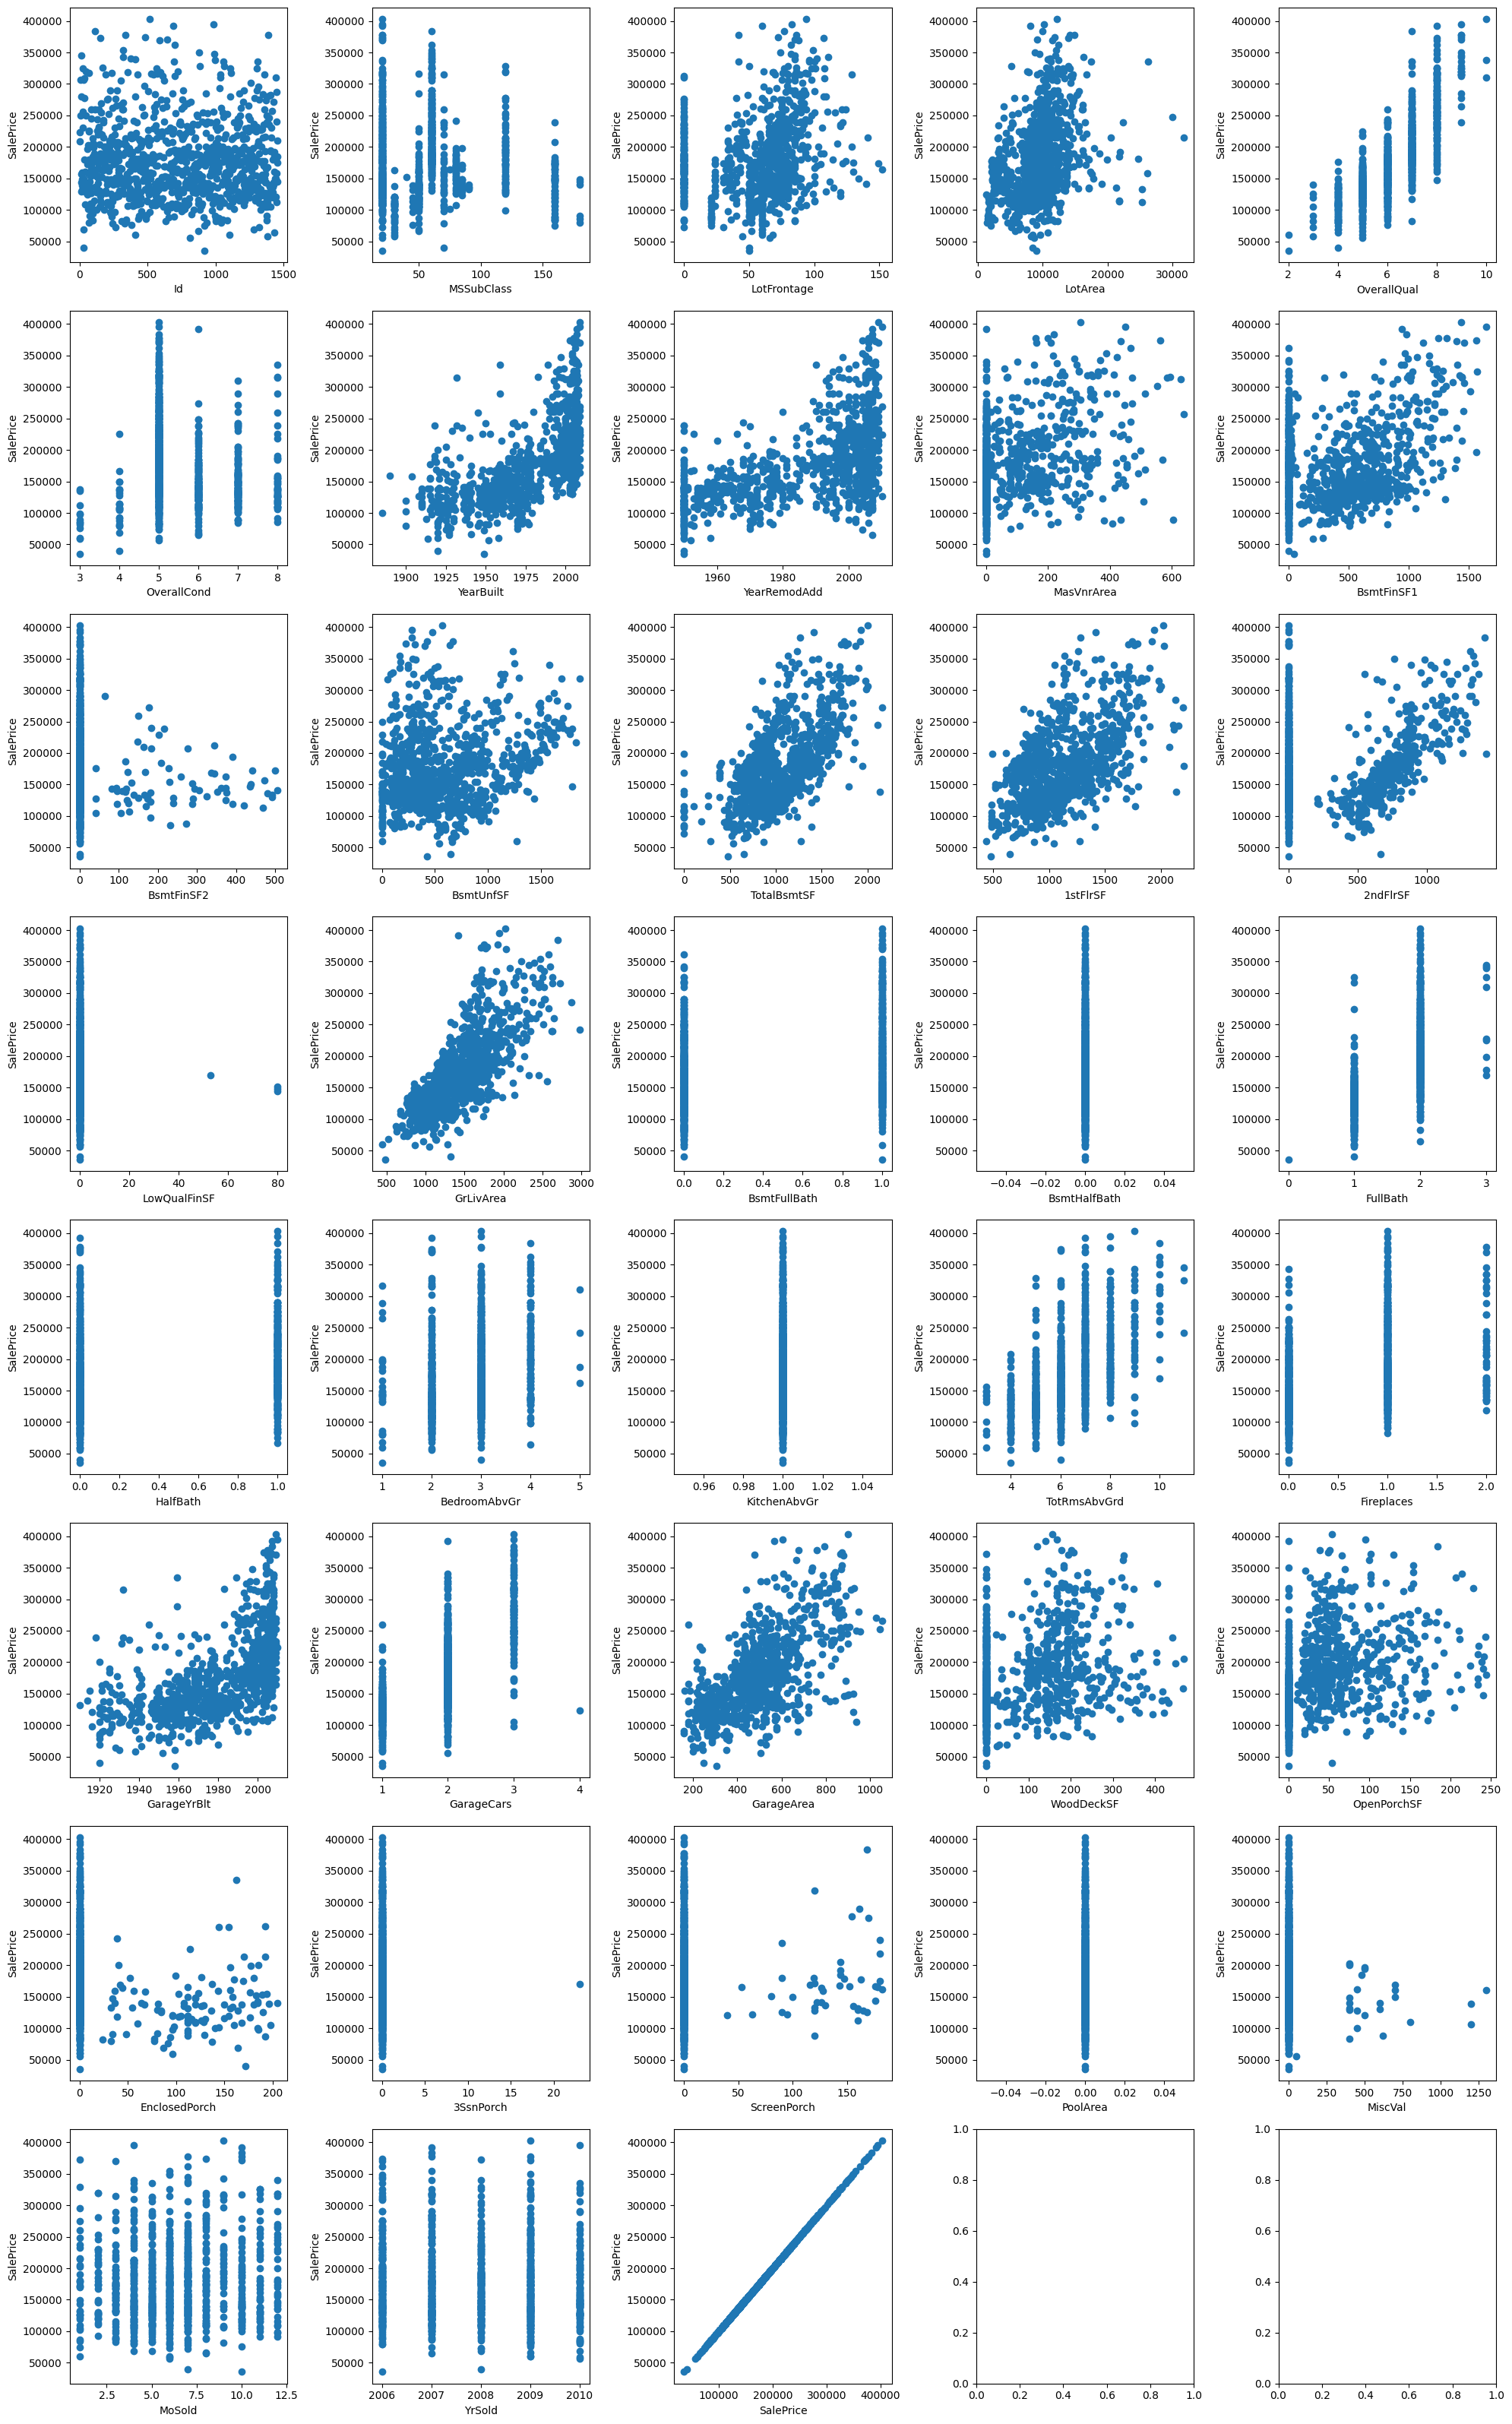

In [14]:
# memvisualisasikan persebaran data numerik pada setiap kolom untuk melihat korelasinya dengan harga rumah
fig, axs = plt.subplots(nrows=len(numeric_cols) // 5 + 1, ncols=5, figsize=(20, 32))
for i, col in enumerate(numeric_cols):
    ax = axs[i // 5][i % 5]
    ax.scatter(x=home_data_train[col], y=home_data_train['SalePrice'])
    ax.set_xlabel(col)
    ax.set_ylabel('SalePrice')
plt.tight_layout()
plt.show()

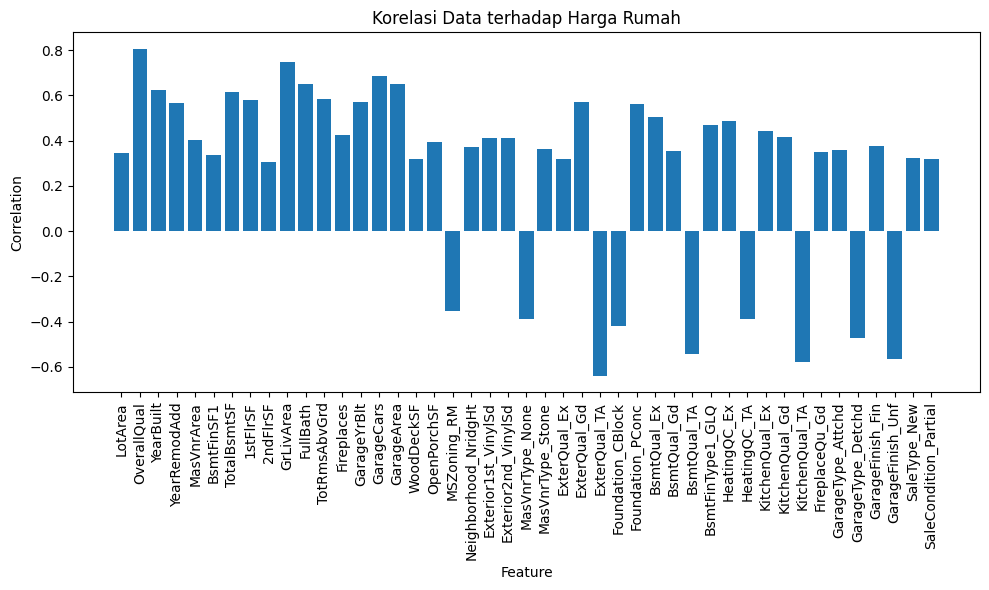

In [15]:
# mencari nilai korelasi setiap kolom terhadap harga rumah
corr_matrix = home_data_train.corr()['SalePrice']

# menghapus kolom harga rumah (tidak digunakan saat ini)
corr_matrix = corr_matrix.drop(index='SalePrice', axis=0)

# mengambil kolom-kolom yang memiliki data dengan nilai korelasi lebih dari sama dengan tiga
correlated_columns = corr_matrix[abs(corr_matrix) >= 0.3]

# Membuat DataFrame untuk menampung data korelasi
correlated_df = pd.DataFrame(correlated_columns)
correlated_df.reset_index(inplace=True)
correlated_df.columns = ['Feature', 'Correlation']

# Menampilkan bar plot
plt.figure(figsize=(10, 6))
plt.bar(correlated_df['Feature'], correlated_df['Correlation'])
plt.xlabel('Feature')
plt.ylabel('Correlation')
plt.title('Korelasi Data terhadap Harga Rumah')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [16]:
# menyimpan kolom yang berkorelasi ke dalam list
correlated_columns = correlated_columns.index.tolist()

print(correlated_columns)

['LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'MSZoning_RM', 'Neighborhood_NridgHt', 'Exterior1st_VinylSd', 'Exterior2nd_VinylSd', 'MasVnrType_None', 'MasVnrType_Stone', 'ExterQual_Ex', 'ExterQual_Gd', 'ExterQual_TA', 'Foundation_CBlock', 'Foundation_PConc', 'BsmtQual_Ex', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtFinType1_GLQ', 'HeatingQC_Ex', 'HeatingQC_TA', 'KitchenQual_Ex', 'KitchenQual_Gd', 'KitchenQual_TA', 'FireplaceQu_Gd', 'GarageType_Attchd', 'GarageType_Detchd', 'GarageFinish_Fin', 'GarageFinish_Unf', 'SaleType_New', 'SaleCondition_Partial']


# Evaluate the Model

data perlu dipisahkan menjadi dua yaitu y-value dan x-value, 
- y-value adalah data pada kolom yang ingin diprediksi,
- x-value adalah data pada kolom-kolom yang berkorelasi dengan harga rumah untuk menghasilkan prediksi.

In [17]:
# y-value
y = home_data_train.SalePrice

# Select columns corresponding to features, and preview the data
X = home_data_train[correlated_columns]
X.head()

,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,...,KitchenQual_Ex,KitchenQual_Gd,KitchenQual_TA,FireplaceQu_Gd,GarageType_Attchd,GarageType_Detchd,GarageFinish_Fin,GarageFinish_Unf,SaleType_New,SaleCondition_Partial
0,8450,7,2003,2003,196.0,706,856,856,854,1710,...,0,1,0,0,1,0,0,0,0,0
2,11250,7,2001,2002,162.0,486,920,920,866,1786,...,0,1,0,0,1,0,0,0,0,0
4,14260,8,2000,2000,350.0,655,1145,1145,1053,2198,...,0,1,0,0,1,0,0,0,0,0
6,10084,8,2004,2005,186.0,1369,1686,1694,0,1694,...,0,1,0,1,1,0,0,0,0,0
10,11200,5,1965,1965,0.0,906,1040,1040,0,1040,...,0,0,1,0,0,1,0,1,0,0


## Decision Tree

In [18]:
# split data into validation and training data
dt_train_X, dt_val_X, dt_train_y, dt_val_y = train_test_split(X, y, test_size=0.2, random_state=1)

# Define, fit, and predict
dt_model = DecisionTreeRegressor(random_state=1)
dt_model.fit(dt_train_X, dt_train_y)
dt_val_predictions = dt_model.predict(dt_val_X)

In [19]:
# Calculate MAE
dt_val_mae = mean_absolute_error(dt_val_y, dt_val_predictions)
print("Mean Absolute Error (MAE):", dt_val_mae)

# Calculate RMSE
dt_val_rmse = mean_squared_error(dt_val_y, dt_val_predictions, squared=False)
print("Root Mean Squared Error (RMSE):", dt_val_rmse)

# Calculate R2 score
dt_val_r2 = r2_score(dt_val_y, dt_val_predictions)
print("R2 Score:", dt_val_r2)

Mean Absolute Error (MAE): 20555.17435897436
Root Mean Squared Error (RMSE): 28891.2788300535
R2 Score: 0.7957046994902178


## Random Forest

In [20]:
# split data into validation and training data
rf_train_X, rf_val_X, rf_train_y, rf_val_y = train_test_split(X, y, test_size=0.2, random_state=1)

# Define, fit, and predict
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(rf_train_X, rf_train_y)
rf_val_predictions = rf_model.predict(rf_val_X)

In [21]:
# Calculate MAE
rf_val_mae = mean_absolute_error(rf_val_y, rf_val_predictions)
print("Mean Absolute Error (MAE):", rf_val_mae)

# Calculate RMSE
rf_val_rmse = mean_squared_error(rf_val_y, rf_val_predictions, squared=False)
print("Root Mean Squared Error (RMSE):", rf_val_rmse)

# Calculate R2 score
rf_val_r2 = r2_score(rf_val_y, rf_val_predictions)
print("R2 Score:", rf_val_r2)

Mean Absolute Error (MAE): 15068.72335775336
Root Mean Squared Error (RMSE): 21021.921018619923
R2 Score: 0.8918392611544423


## Hasil Evaluasi

In [22]:
evaluation_models = pd.DataFrame(
    data={
      'decision tree': [dt_val_mae, dt_val_rmse, dt_val_r2], 
      'random forest': [rf_val_mae, rf_val_rmse, rf_val_r2]
    }, 
    index=["MAE", "RMSE", "R2 Score"]
    )

evaluation_models

,decision tree,random forest
MAE,20555.174359,15068.723358
RMSE,28891.278830,21021.921019
R2 Score,0.795705,0.891839


## Perbandingan Hasil DT dan RF

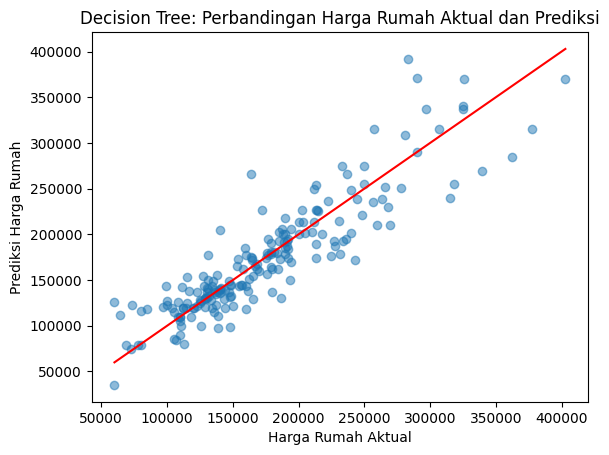

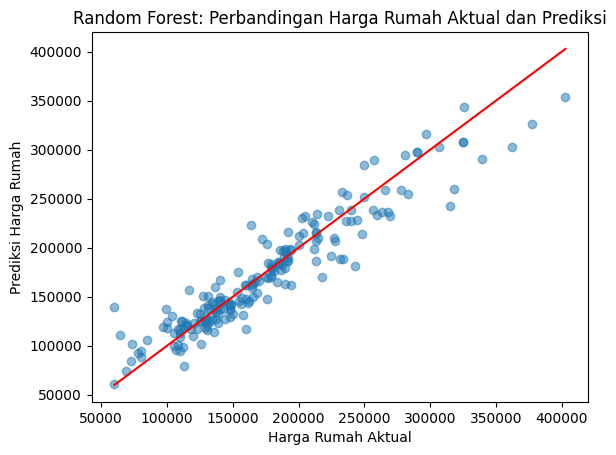

In [23]:
# Define a function to plot actual vs predicted values
def plot_predictions(y_test, y_pred, model_name):
  # Create a scatter plot of actual vs predicted values
  plt.scatter(y_test, y_pred, alpha=0.5)
  # Add a reference line
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red")
  # Add labels and title
  plt.xlabel("Harga Rumah Aktual")
  plt.ylabel("Prediksi Harga Rumah")
  plt.title(f"{model_name}: Perbandingan Harga Rumah Aktual dan Prediksi")
  # Show the plot
  plt.show()

# Plot the predictions for each model
plot_predictions(dt_val_y, dt_val_predictions, "Decision Tree")
plot_predictions(rf_val_y, rf_val_predictions, "Random Forest")

## Variabel Paling Berpengaruh

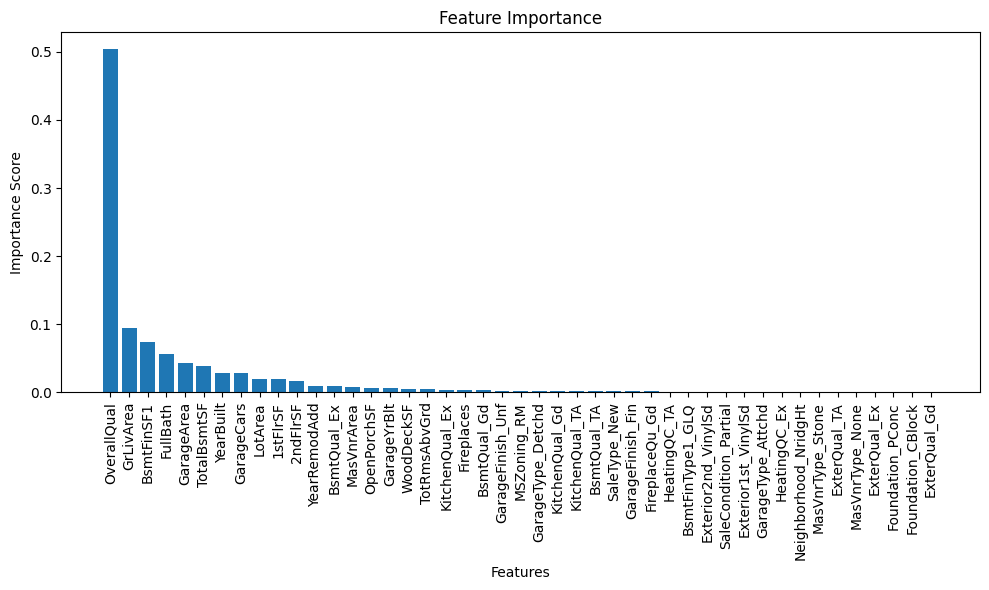

In [24]:
feature_importances = rf_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_feature_importances)), sorted_feature_importances)
plt.xticks(range(len(sorted_feature_importances)), rf_train_X.columns[sorted_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Create Prediction

## Melakukan pengujian terhadap model random forest

Setelah model kira-kira siap untuk digunakan, langkah selanjutnya adalah melakukan pembelajaran model kembali namun dengan menggunakan seluruh data_training sebagai bahan pembelajarannya. ini bertujuan untuk meningkatkan keakuratan model

In [25]:
# To improve accuracy, create a new Random Forest model which you will train on all training data
rf_model_on_full_data = RandomForestRegressor(random_state=1)

# fit rf_model_on_full_data on all data from the training data
rf_model_on_full_data.fit(X, y)

RandomForestRegressor(random_state=1)

## Bersihkan Data

In [26]:
# mengisi data numerik yang kosong
for col in home_data_test.select_dtypes(include=[np.number]).columns.tolist():
  if home_data_test[col].isna().sum() > 0:
    home_data_test[col] = home_data_test[col].fillna(0)

# mengubah data non-numerik menjadi data numerik menggunkan metode one-hot encoding
for col in home_data_test.select_dtypes(exclude=[np.number]).columns.tolist():
    dummies = pd.get_dummies(home_data_test[col], prefix=col)
    home_data_test = pd.concat([home_data_test, dummies], axis=1)
    home_data_test.drop(col, axis=1, inplace=True)

## Buat Prediksi

In [27]:
# create test_X which comes from test_data but includes only the columns you used for prediction.
# The list of columns is stored in a variable called features
test_X = home_data_test[correlated_columns].copy()

# make predictions which we will submit. 
test_preds = rf_model_on_full_data.predict(test_X)
print(test_preds[:10].tolist())

[125815.0, 148246.37, 185684.0, 184501.3, 196814.99, 186649.5, 163782.51, 174735.37, 176579.77, 122120.5]


# Generate a submission

In [28]:
# Run the code to save predictions in the format used for competition scoring

output = pd.DataFrame({'Id': home_data_test.Id,
                       'SalePrice': test_preds})
output.to_csv('submission.csv', index=False)

# From Kaggle

In [29]:
# Check your answer (To get credit for completing the exercise, you must get a "Correct" result!)
step_1.check()
step_1.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python

# In previous code cell
rf_model_on_full_data = RandomForestRegressor()
rf_model_on_full_data.fit(X, y)

# Then in last code cell
test_data_path = '../input/test.csv'
test_data = pd.read_csv(test_data_path)
test_X = test_data[features]
test_preds = rf_model_on_full_data.predict(test_X)


output = pd.DataFrame({'Id': test_data.Id,
                       'SalePrice': test_preds})
output.to_csv('submission.csv', index=False)

```

## Submit to the competition

To test your results, you'll need to join the competition (if you haven't already).  So open a new window by clicking on **[this link](https://www.kaggle.com/c/home-data-for-ml-course)**.  Then click on the **Join Competition** button.

![join competition image](https://storage.googleapis.com/kaggle-media/learn/images/axBzctl.png)

Next, follow the instructions below:
1. Begin by clicking on the **Save Version** button in the top right corner of the window.  This will generate a pop-up window.  
2. Ensure that the **Save and Run All** option is selected, and then click on the **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Data** tab near the top of the screen.  Then, click on the file you would like to submit, and click on the **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

If you want to keep working to improve your performance, select the **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.


## Continue Your Progress
There are many ways to improve your model, and **experimenting is a great way to learn at this point.**

The best way to improve your model is to add features.  To add more features to the data, revisit the first code cell, and change this line of code to include more column names:
```python
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
```

Some features will cause errors because of issues like missing values or non-numeric data types.  Here is a complete list of potential columns that you might like to use, and that won't throw errors:
- 'MSSubClass'
- 'LotArea'
- 'OverallQual' 
- 'OverallCond' 
- 'YearBuilt'
- 'YearRemodAdd' 
- '1stFlrSF'
- '2ndFlrSF' 
- 'LowQualFinSF' 
- 'GrLivArea'
- 'FullBath'
- 'HalfBath'
- 'BedroomAbvGr' 
- 'KitchenAbvGr' 
- 'TotRmsAbvGrd' 
- 'Fireplaces' 
- 'WoodDeckSF' 
- 'OpenPorchSF'
- 'EnclosedPorch' 
- '3SsnPorch' 
- 'ScreenPorch' 
- 'PoolArea' 
- 'MiscVal' 
- 'MoSold' 
- 'YrSold'

Look at the list of columns and think about what might affect home prices.  To learn more about each of these features, take a look at the data description on the **[competition page](https://www.kaggle.com/c/home-data-for-ml-course/data)**.

After updating the code cell above that defines the features, re-run all of the code cells to evaluate the model and generate a new submission file.  


## What's next?

As mentioned above, some of the features will throw an error if you try to use them to train your model.  The **[Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning)** course will teach you how to handle these types of features. You will also learn to use **xgboost**, a technique giving even better accuracy than Random Forest.

The **[Pandas](https://kaggle.com/Learn/Pandas)** course will give you the data manipulation skills to quickly go from conceptual idea to implementation in your data science projects. 

You are also ready for the **[Deep Learning](https://kaggle.com/Learn/intro-to-Deep-Learning)** course, where you will build models with better-than-human level performance at computer vision tasks.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/intro-to-machine-learning/discussion) to chat with other learners.*